In [1]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import umap
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import re
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [15]:
train = pd.read_csv("/content/train_data.csv")
train_true = pd.read_csv("/content/train_data.csv")
test_data = pd.read_csv("/content/test_data.csv")

In [16]:
# 最後のデータ結合の為idは別で保存しておく
iddf = test_data[["id"]]

train.head()

,id,video_id,title,publishedAt,channelId,channelTitle,categoryId,collection_date,tags,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,y
0,1,GDtyztIThRQ,[12] BGM Inazuma Eleven 3 - ~ライオコツト ダンジョン~,2011-01-09T05:50:33.000Z,UCQaNYC3dNvH8FqrEyK7hTJw,DjangoShiny,20,20.01.02,Inazuma|Eleven|Super|Once|bgm|ost|イナズマイレブン|Kyo...,114,0,7,https://i.ytimg.com/vi/GDtyztIThRQ/default.jpg,False,False,~ライオコツト ダンジョン~Inazuma Eleven 3 BGM Complete (R...,29229
1,2,m4H9s3GtTlQ,ねごと - メルシールー [Official Music Video],2012-07-23T03:00:09.000Z,UChMWDi-HBm5aS3jyRSaAWUA,ねごと Official Channel,10,20.08.02,ねごと|ネゴト|メルシールー|Re:myend|リマインド|Lightdentity|ライデ...,2885,50,111,https://i.ytimg.com/vi/m4H9s3GtTlQ/default.jpg,False,False,http://www.negoto.com/全員平成生まれ、蒼山幸子（Vo＆Key)、沙田瑞...,730280
2,3,z19zYZuLuEU,VF3tb 闇よだれvsちび太 (SEGA),2007-07-26T13:54:09.000Z,UCBdcyoZSt5HBLd_n6we-xIg,siropai,24,20.14.01,VF3|VF4|VF5|ちび太|闇よだれ|chibita|virtuafighter|seg...,133,17,14,https://i.ytimg.com/vi/z19zYZuLuEU/default.jpg,False,False,Beat-tribe cup finalhttp://ameblo.jp/siropai/,80667
3,4,pmcIOsL7s98,free frosty weekend!,2005-05-15T02:38:43.000Z,UC7K5am1UAQEsCRhzXpi9i1g,Jones4Carrie,22,19.22.12,frosty,287,51,173,https://i.ytimg.com/vi/pmcIOsL7s98/default.jpg,False,False,I look so bad but look at me!,34826
4,5,ZuQgsTcuM-4,トップ・オブ・ザ・ワールド,2007-09-09T09:52:47.000Z,UCTW1um4R-QWa8iIfITGvlZQ,Tatsuya Maruyama,10,20.08.01,ギター|guitar|南澤大介|トップオブザワールド|トップ|オブ|ワールド|カーペンターズ...,178,6,17,https://i.ytimg.com/vi/ZuQgsTcuM-4/default.jpg,False,False,ソロギターのしらべより「トップオブザワールド」です。クラシックギターで弾いてます。Offic...,172727


(array([1.9624e+04, 5.4000e+01, 1.3000e+01, 8.0000e+00, 6.0000e+00,
        4.0000e+00, 4.0000e+00, 2.0000e+00, 0.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([2.00000000e+00, 1.07128023e+08, 2.14256043e+08, 3.21384064e+08,
        4.28512085e+08, 5.35640106e+08, 6.42768126e+08, 7.49896147e+08,
        8.57024168e+08, 9.64152188e+08, 1.07128021e+09, 1.17840823e+09,
        1.28553625e+09, 1.39266427e+09, 1.49979229e+09, 1.60692031e+09,
        1.71404833e+09, 1.82117635e+09, 1.92830437e+09, 2.03543240e+09,
        2.14256042e+09]),
 <a list of 20 Patch objects>)

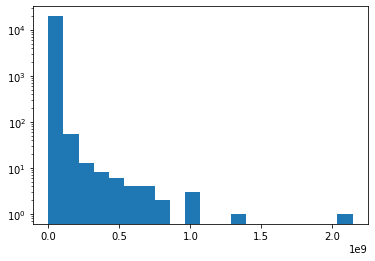

In [17]:
# 目的変数を可視化する
plt.hist(train['y'], bins=20, log=True)

In [18]:
# 訓練データとテストデータを別々で処理するのは面倒なので、結合して前処理していく
data = pd.concat([train, test_data])

# あとでテストと訓練を分別できる様に訓練データの長さを保存
train_len = len(train["y"])
print(train.shape, test_data.shape, data.shape)

(19720, 17) (29582, 16) (49302, 17)


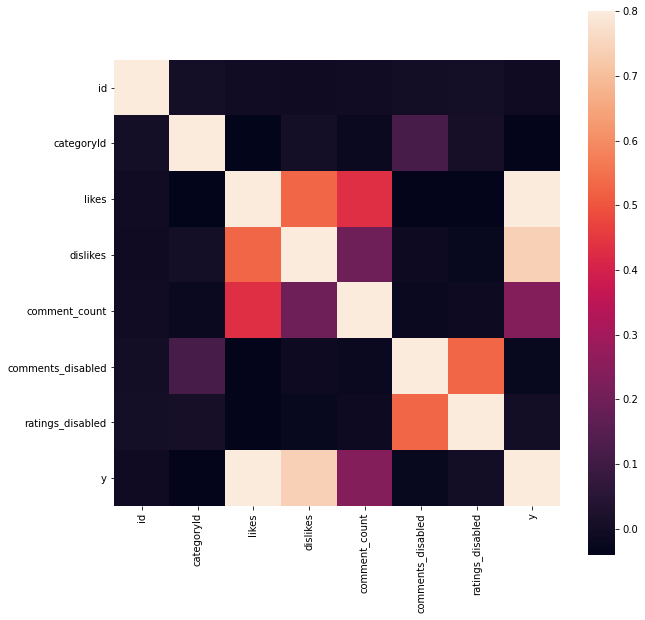

In [19]:
# 相関係数を見て、関係のありそうな説明変数を見る
corrmat = data.corr()
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corrmat, vmax=.8, square=True)
# 下の相関係数の図からyとはlikes,dislikes,comment_countがかろうじて高いと分かる

In [20]:
# 各IDに所属しているyの「平均値、最大値、最小値、標準偏差、個数」
mean_ = train[["categoryId", "y"]].groupby(
    "categoryId").mean().reset_index().rename({"y": "mean"}, axis=1)
max_ = train[["categoryId", "y"]].groupby(
    "categoryId").max().reset_index().rename({"y": "max"}, axis=1)
min_ = train[["categoryId", "y"]].groupby(
    "categoryId").min().reset_index().rename({"y": "min"}, axis=1)
std_ = train[["categoryId", "y"]].groupby(
    "categoryId").std().reset_index().rename({"y": "std"}, axis=1)
count_ = train[["categoryId", "y"]].groupby(
    "categoryId").count().reset_index().rename({"y": "count"}, axis=1)

In [21]:
# 各IDの部位点
q1_ = train[["categoryId", "y"]].groupby("categoryId").quantile(
    0.1).reset_index().rename({"y": "q1"}, axis=1)
q25_ = train[["categoryId", "y"]].groupby("categoryId").quantile(
    0.25).reset_index().rename({"y": "q25"}, axis=1)
q5_ = train[["categoryId", "y"]].groupby("categoryId").quantile(
    0.5).reset_index().rename({"y": "q5"}, axis=1)
q75_ = train[["categoryId", "y"]].groupby("categoryId").quantile(
    0.75).reset_index().rename({"y": "q75"}, axis=1)
q9_ = train[["categoryId", "y"]].groupby("categoryId").quantile(
    0.9).reset_index().rename({"y": "q9"}, axis=1)

In [22]:
# 目的変数を対数変換して、正則化してからドロップする
train["y"] = np.log1p(train["y"])
y = train["y"]
del train["y"]

In [23]:
# 型をbool方からintに変換
data["comments_disabled"] = data["comments_disabled"].astype(np.int16)
data["ratings_disabled"] = data["ratings_disabled"].astype(np.int16)
# False = 0: True = 1

In [24]:
# like dislike comment
#data["likes2"] = data["likes"]**2
data["loglikes"] = np.log(data["likes"]+1)
#data["dislikes2"] = data["dislikes"]**2
data["logdislikes"] = np.log(data["dislikes"]+1)
data["logcomment_count"] = np.log(data["comment_count"]+1)

data["sqrtlikes"] = np.sqrt(data["likes"])

In [25]:
# ここの+1は何かの微調整わからん。。
data["like_dislike_ratio"] = data["likes"]/(data["dislikes"]+1)
data["comments_like_ratio"] = data["comment_count"]/(data["likes"]+1)
data["comments_dislike_ratio"] = data["comment_count"]/(data["dislikes"]+1)

In [26]:
# likes comments diable
data["likes_com"] = data["likes"] * data["comments_disabled"]
data["dislikes_com"] = data["dislikes"] * data["comments_disabled"]
data["comments_likes"] = data["comment_count"] * data["ratings_disabled"]

In [27]:
# tag
# 欠損値を処理
data["tags"].fillna("[none]", inplace=True)

# "|"を含んでいる文で、"|"で区切って、カウントして、ソート
# それぞれのtagの出現回数を表している
tagdic = dict(pd.Series("|".join(list(data["tags"])).split(
    "|")).value_counts().sort_values())

# tagの個数をカウント
data["num_tags"] = data["tags"].astype(str).apply(lambda x: len(x.split("|")))

# 文字数
data["length_tags"] = data["tags"].astype(str).apply(lambda x: len(x))

# 使っているtagをtagdicでポイント化して、マイナーか、有名なtagを使っているかを判定できる
data["tags_point"] = data["tags"].apply(
    lambda tags: sum([tagdic[tag] for tag in tags.split("|")]))

data.head()

,id,video_id,title,publishedAt,channelId,channelTitle,categoryId,collection_date,tags,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,y,loglikes,logdislikes,logcomment_count,sqrtlikes,like_dislike_ratio,comments_like_ratio,comments_dislike_ratio,likes_com,dislikes_com,comments_likes,num_tags,length_tags,tags_point
0,1,GDtyztIThRQ,[12] BGM Inazuma Eleven 3 - ~ライオコツト ダンジョン~,2011-01-09T05:50:33.000Z,UCQaNYC3dNvH8FqrEyK7hTJw,DjangoShiny,20,20.01.02,Inazuma|Eleven|Super|Once|bgm|ost|イナズマイレブン|Kyo...,114,0,7,https://i.ytimg.com/vi/GDtyztIThRQ/default.jpg,0,0,~ライオコツト ダンジョン~Inazuma Eleven 3 BGM Complete (R...,29229.0,4.744932,0.000000,2.079442,10.677078,114.000000,0.060870,7.000000,0,0,0,48,315,5434
1,2,m4H9s3GtTlQ,ねごと - メルシールー [Official Music Video],2012-07-23T03:00:09.000Z,UChMWDi-HBm5aS3jyRSaAWUA,ねごと Official Channel,10,20.08.02,ねごと|ネゴト|メルシールー|Re:myend|リマインド|Lightdentity|ライデ...,2885,50,111,https://i.ytimg.com/vi/m4H9s3GtTlQ/default.jpg,0,0,http://www.negoto.com/全員平成生まれ、蒼山幸子（Vo＆Key)、沙田瑞...,730280.0,7.967627,3.931826,4.718499,53.712196,56.568627,0.038462,2.176471,0,0,0,19,129,76
2,3,z19zYZuLuEU,VF3tb 闇よだれvsちび太 (SEGA),2007-07-26T13:54:09.000Z,UCBdcyoZSt5HBLd_n6we-xIg,siropai,24,20.14.01,VF3|VF4|VF5|ちび太|闇よだれ|chibita|virtuafighter|seg...,133,17,14,https://i.ytimg.com/vi/z19zYZuLuEU/default.jpg,0,0,Beat-tribe cup finalhttp://ameblo.jp/siropai/,80667.0,4.897840,2.890372,2.708050,11.532563,7.388889,0.104478,0.777778,0,0,0,9,52,49
3,4,pmcIOsL7s98,free frosty weekend!,2005-05-15T02:38:43.000Z,UC7K5am1UAQEsCRhzXpi9i1g,Jones4Carrie,22,19.22.12,frosty,287,51,173,https://i.ytimg.com/vi/pmcIOsL7s98/default.jpg,0,0,I look so bad but look at me!,34826.0,5.662960,3.951244,5.159055,16.941074,5.519231,0.600694,3.326923,0,0,0,1,6,2
4,5,ZuQgsTcuM-4,トップ・オブ・ザ・ワールド,2007-09-09T09:52:47.000Z,UCTW1um4R-QWa8iIfITGvlZQ,Tatsuya Maruyama,10,20.08.01,ギター|guitar|南澤大介|トップオブザワールド|トップ|オブ|ワールド|カーペンターズ...,178,6,17,https://i.ytimg.com/vi/ZuQgsTcuM-4/default.jpg,0,0,ソロギターのしらべより「トップオブザワールド」です。クラシックギターで弾いてます。Offic...,172727.0,5.187386,1.945910,2.890372,13.341664,25.428571,0.094972,2.428571,0,0,0,12,83,850


In [28]:
# 日付型に変換
data["publishedAt"] = pd.to_datetime(data["publishedAt"], utc=True)

data["publishedAt_year"] = data["publishedAt"].apply(lambda x: x.year)
data["publishedAt_month"] = data["publishedAt"].apply(lambda x: x.month)
data["publishedAt_day"] = data["publishedAt"].apply(lambda x: x.day)
data["publishedAt_hour"] = data["publishedAt"].apply(lambda x: x.hour)
data["publishedAt_minute"] = data["publishedAt"].apply(lambda x: x.minute)
#df["publishedAt_second"] = df["publishedAt"].apply(lambda x: x.second)
data["publishedAt_dayofweek"] = data["publishedAt"].apply(
    lambda x: x.dayofweek)

#df["collection_date_year"] = df["collection_date"].apply(lambda x: int(x[0:2]))
data["collection_date_month"] = data["collection_date"].apply(
    lambda x: int(x[3:5]))
data["collection_date_day"] = data["collection_date"].apply(
    lambda x: int(x[6:8]))

# "collection_date"をdatetime型に変換
data["collection_date"] = pd.to_datetime(
    "20"+data["collection_date"], format="%Y.%d.%m", utc=True)
data.head()

,id,video_id,title,publishedAt,channelId,channelTitle,categoryId,collection_date,tags,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,y,loglikes,logdislikes,logcomment_count,sqrtlikes,like_dislike_ratio,comments_like_ratio,comments_dislike_ratio,likes_com,dislikes_com,comments_likes,num_tags,length_tags,tags_point,publishedAt_year,publishedAt_month,publishedAt_day,publishedAt_hour,publishedAt_minute,publishedAt_dayofweek,collection_date_month,collection_date_day
0,1,GDtyztIThRQ,[12] BGM Inazuma Eleven 3 - ~ライオコツト ダンジョン~,2011-01-09 05:50:33+00:00,UCQaNYC3dNvH8FqrEyK7hTJw,DjangoShiny,20,2020-02-01 00:00:00+00:00,Inazuma|Eleven|Super|Once|bgm|ost|イナズマイレブン|Kyo...,114,0,7,https://i.ytimg.com/vi/GDtyztIThRQ/default.jpg,0,0,~ライオコツト ダンジョン~Inazuma Eleven 3 BGM Complete (R...,29229.0,4.744932,0.000000,2.079442,10.677078,114.000000,0.060870,7.000000,0,0,0,48,315,5434,2011,1,9,5,50,6,1,2
1,2,m4H9s3GtTlQ,ねごと - メルシールー [Official Music Video],2012-07-23 03:00:09+00:00,UChMWDi-HBm5aS3jyRSaAWUA,ねごと Official Channel,10,2020-02-08 00:00:00+00:00,ねごと|ネゴト|メルシールー|Re:myend|リマインド|Lightdentity|ライデ...,2885,50,111,https://i.ytimg.com/vi/m4H9s3GtTlQ/default.jpg,0,0,http://www.negoto.com/全員平成生まれ、蒼山幸子（Vo＆Key)、沙田瑞...,730280.0,7.967627,3.931826,4.718499,53.712196,56.568627,0.038462,2.176471,0,0,0,19,129,76,2012,7,23,3,0,0,8,2
2,3,z19zYZuLuEU,VF3tb 闇よだれvsちび太 (SEGA),2007-07-26 13:54:09+00:00,UCBdcyoZSt5HBLd_n6we-xIg,siropai,24,2020-01-14 00:00:00+00:00,VF3|VF4|VF5|ちび太|闇よだれ|chibita|virtuafighter|seg...,133,17,14,https://i.ytimg.com/vi/z19zYZuLuEU/default.jpg,0,0,Beat-tribe cup finalhttp://ameblo.jp/siropai/,80667.0,4.897840,2.890372,2.708050,11.532563,7.388889,0.104478,0.777778,0,0,0,9,52,49,2007,7,26,13,54,3,14,1
3,4,pmcIOsL7s98,free frosty weekend!,2005-05-15 02:38:43+00:00,UC7K5am1UAQEsCRhzXpi9i1g,Jones4Carrie,22,2019-12-22 00:00:00+00:00,frosty,287,51,173,https://i.ytimg.com/vi/pmcIOsL7s98/default.jpg,0,0,I look so bad but look at me!,34826.0,5.662960,3.951244,5.159055,16.941074,5.519231,0.600694,3.326923,0,0,0,1,6,2,2005,5,15,2,38,6,22,12
4,5,ZuQgsTcuM-4,トップ・オブ・ザ・ワールド,2007-09-09 09:52:47+00:00,UCTW1um4R-QWa8iIfITGvlZQ,Tatsuya Maruyama,10,2020-01-08 00:00:00+00:00,ギター|guitar|南澤大介|トップオブザワールド|トップ|オブ|ワールド|カーペンターズ...,178,6,17,https://i.ytimg.com/vi/ZuQgsTcuM-4/default.jpg,0,0,ソロギターのしらべより「トップオブザワールド」です。クラシックギターで弾いてます。Offic...,172727.0,5.187386,1.945910,2.890372,13.341664,25.428571,0.094972,2.428571,0,0,0,12,83,850,2007,9,9,9,52,6,8,1


In [29]:
# delta
# 公開日からデータ収集日までの期間
data["delta"] = (data["collection_date"] -
                 data["publishedAt"]).apply(lambda x: x.days)

data["logdelta"] = np.log(data["delta"])
data["sqrtdelta"] = np.sqrt(data["delta"])


data["published_delta"] = (data["publishedAt"] -
                           data["publishedAt"].min()).apply(lambda x: x.days)
data["collection_delta"] = (
    data["collection_date"] - data["collection_date"].min()).apply(lambda x: x.days)

# 欠損値は空白は埋める
data["description"].fillna(" ", inplace=True)

# 全てを小文字に変換して、httpをカウント
data["ishttp_in_dis"] = data["description"].apply(
    lambda x: x.lower().count("http"))

# descriptionの長さ
data["len_description"] = data["description"].apply(lambda x: len(x))

data["title"].fillna(" ", inplace=True)
# 欠損値がある場合空白で埋める

data["len_title"] = data["title"].apply(lambda x: len(x))
# タイトルの長さ

In [30]:
# 文字列stringに1文字でも「ひらがな」「カタカナ」「漢字」のどれかが含まれていればTrueを返します

def is_japanese(string):
    for ch in string:
        try:
            name = unicodedata.name(ch)
            if "CJK UNIFIED" in name \
                    or "HIRAGANA" in name \
                    or "KATAKANA" in name:
                return True
        except:
            continue
    return False


# is japanese
data["isJa_title"] = data["title"].apply(lambda x: is_japanese(x))
data["isJa_tags"] = data["tags"].apply(lambda x: is_japanese(x))
data["isJa_description"] = data["description"].apply(lambda x: is_japanese(x))

# is englosh
# 全てが英数字のみか判定する
# 文字コードを指定しないとうまく判定できない
data["onEn_title"] = data["title"].apply(lambda x: x.encode('utf-8').isalnum())
data["onEn_tags"] = data["tags"].apply(lambda x: x.encode('utf-8').isalnum())
data["onEn_description"] = data["description"].apply(
    lambda x: x.encode('utf-8').isalnum())


# cotain englosh
# findallはマッチするすべての部分文字列をリストにして返す
# またlenを使ってリストの長さを図ることで、マッチした文字の長さだけを見ることができる
# x.lowerを使う理由は処理が多少早くなるから！  (使わなくても結果は変わらない)
data["conEn_title"] = data["title"].apply(
    lambda x: len(re.findall(r'[a-zA-Z0-9]', x.lower())))
data["conEn_tags"] = data["tags"].apply(
    lambda x: len(re.findall(r'[a-zA-Z0-9]', x.lower())))
data["conEn_description"] = data["description"].apply(
    lambda x: len(re.findall(r'[a-zA-Z0-9]', x.lower())))

data.head()

,id,video_id,title,publishedAt,channelId,channelTitle,categoryId,collection_date,tags,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,y,loglikes,logdislikes,logcomment_count,sqrtlikes,like_dislike_ratio,comments_like_ratio,comments_dislike_ratio,likes_com,dislikes_com,comments_likes,num_tags,length_tags,tags_point,publishedAt_year,publishedAt_month,publishedAt_day,publishedAt_hour,publishedAt_minute,publishedAt_dayofweek,collection_date_month,collection_date_day,delta,logdelta,sqrtdelta,published_delta,collection_delta,ishttp_in_dis,len_description,len_title,isJa_title,isJa_tags,isJa_description,onEn_title,onEn_tags,onEn_description,conEn_title,conEn_tags,conEn_description
0,1,GDtyztIThRQ,[12] BGM Inazuma Eleven 3 - ~ライオコツト ダンジョン~,2011-01-09 05:50:33+00:00,UCQaNYC3dNvH8FqrEyK7hTJw,DjangoShiny,20,2020-02-01 00:00:00+00:00,Inazuma|Eleven|Super|Once|bgm|ost|イナズマイレブン|Kyo...,114,0,7,https://i.ytimg.com/vi/GDtyztIThRQ/default.jpg,0,0,~ライオコツト ダンジョン~Inazuma Eleven 3 BGM Complete (R...,29229.0,4.744932,0.000000,2.079442,10.677078,114.000000,0.060870,7.000000,0,0,0,48,315,5434,2011,1,9,5,50,6,1,2,3309,8.104401,57.523908,2086,41,0,61,42,True,True,True,False,False,False,19,258,38
1,2,m4H9s3GtTlQ,ねごと - メルシールー [Official Music Video],2012-07-23 03:00:09+00:00,UChMWDi-HBm5aS3jyRSaAWUA,ねごと Official Channel,10,2020-02-08 00:00:00+00:00,ねごと|ネゴト|メルシールー|Re:myend|リマインド|Lightdentity|ライデ...,2885,50,111,https://i.ytimg.com/vi/m4H9s3GtTlQ/default.jpg,0,0,http://www.negoto.com/全員平成生まれ、蒼山幸子（Vo＆Key)、沙田瑞...,730280.0,7.967627,3.931826,4.718499,53.712196,56.568627,0.038462,2.176471,0,0,0,19,129,76,2012,7,23,3,0,0,8,2,2755,7.921173,52.488094,2646,48,1,261,35,True,True,True,False,False,False,18,38,54
2,3,z19zYZuLuEU,VF3tb 闇よだれvsちび太 (SEGA),2007-07-26 13:54:09+00:00,UCBdcyoZSt5HBLd_n6we-xIg,siropai,24,2020-01-14 00:00:00+00:00,VF3|VF4|VF5|ちび太|闇よだれ|chibita|virtuafighter|seg...,133,17,14,https://i.ytimg.com/vi/z19zYZuLuEU/default.jpg,0,0,Beat-tribe cup finalhttp://ameblo.jp/siropai/,80667.0,4.897840,2.890372,2.708050,11.532563,7.388889,0.104478,0.777778,0,0,0,9,52,49,2007,7,26,13,54,3,14,1,4554,8.423761,67.483331,823,23,1,45,22,True,True,False,False,False,False,11,33,36
3,4,pmcIOsL7s98,free frosty weekend!,2005-05-15 02:38:43+00:00,UC7K5am1UAQEsCRhzXpi9i1g,Jones4Carrie,22,2019-12-22 00:00:00+00:00,frosty,287,51,173,https://i.ytimg.com/vi/pmcIOsL7s98/default.jpg,0,0,I look so bad but look at me!,34826.0,5.662960,3.951244,5.159055,16.941074,5.519231,0.600694,3.326923,0,0,0,1,6,2,2005,5,15,2,38,6,22,12,5333,8.581669,73.027392,20,0,0,30,20,False,False,False,False,True,False,17,6,21
4,5,ZuQgsTcuM-4,トップ・オブ・ザ・ワールド,2007-09-09 09:52:47+00:00,UCTW1um4R-QWa8iIfITGvlZQ,Tatsuya Maruyama,10,2020-01-08 00:00:00+00:00,ギター|guitar|南澤大介|トップオブザワールド|トップ|オブ|ワールド|カーペンターズ...,178,6,17,https://i.ytimg.com/vi/ZuQgsTcuM-4/default.jpg,0,0,ソロギターのしらべより「トップオブザワールド」です。クラシックギターで弾いてます。Offic...,172727.0,5.187386,1.945910,2.890372,13.341664,25.428571,0.094972,2.428571,0,0,0,12,83,850,2007,9,9,9,52,6,8,1,4503,8.412499,67.104396,868,17,2,138,13,True,True,True,False,False,False,0,10,79


In [31]:
# Music
data["music_title"] = data["title"].apply(lambda x: "music" in x.lower())
data["music_tags"] = data["tags"].apply(lambda x: "music" in x.lower())
data["music_description"] = data["description"].apply(
    lambda x: "music" in x.lower())

In [32]:
# Official
data["isOff"] = data["title"].apply(lambda x: "fficial" in x.lower())
data["isOffChannell"] = data["channelTitle"].apply(
    lambda x: "fficial" in x.lower())
data["isOffJa"] = data["title"].apply(lambda x: "公式" in x.lower())
data["isOffChannellJa"] = data["channelTitle"].apply(
    lambda x: "公式" in x.lower())
# 公式アカウントを知るために、"公式"と"fficialの2パターンを考える
# fficalの理由は Oが大文字と小文字、空白がある場合があるから

In [33]:
# CMの場合の処理
data["cm_title"] = data["title"].apply(lambda x: "cm" in x.lower())
data["cm_tags"] = data["tags"].apply(lambda x: "cm" in x.lower())
data["cm_description"] = data["description"].apply(lambda x: "cm" in x.lower())


In [34]:
# 最初に求めた奴の結合
data = data.merge(mean_, how='left', on=["categoryId"])
data = data.merge(max_, how='left', on=["categoryId"])
data = data.merge(min_, how='left', on=["categoryId"])
data = data.merge(std_, how='left', on=["categoryId"])
#data = df.merge(count_, how='left', on=["categoryId"])
data = data.merge(q1_, how='left', on=["categoryId"])
data = data.merge(q25_, how='left', on=["categoryId"])
data = data.merge(q5_, how='left', on=["categoryId"])
data = data.merge(q75_, how='left', on=["categoryId"])
data = data.merge(q9_, how='left', on=["categoryId"])

In [35]:
# 出現頻度

for col in ["categoryId", "channelTitle"]:
    freq = data[col].value_counts()
    # map(freq)で{1:10,2:30}とかになっている
    data["freq_"+col] = data[col].map(freq)


# 表示される列数と、行数を増やした
# 削除する列の確認が不便だったので追加した
pd.set_option('display.max_columns', 68)
pd.set_option('display.max_rows', 100)

del data["id"]
del data["video_id"]
del data["title"]
del data["publishedAt"]
del data["channelId"]
del data["channelTitle"]
del data["collection_date"]
del data["tags"]
del data["thumbnail_link"]
del data["description"]
del data["y"]

In [36]:
# ここの欠損地は全てテストデータの物なので偏らない様に最近傍法用のデータを作る
data_kmeans = data
data_kmeans["mean"] = data["mean"].fillna(np.mean(data["mean"]))
data_kmeans["max"] = data["max"].fillna(np.mean(data["max"]))
data_kmeans["min"] = data["min"].fillna(np.mean(data["min"]))
data_kmeans["std"] = data["std"].fillna(np.mean(data["std"]))
data_kmeans["q1"] = data["q1"].fillna(np.mean(data["q1"]))
data_kmeans["q25"] = data["q25"].fillna(np.mean(data["q25"]))
data_kmeans["q5"] = data["q5"].fillna(np.mean(data["q5"]))
data_kmeans["q75"] = data["q75"].fillna(np.mean(data["q75"]))
data_kmeans["q9"] = data["q9"].fillna(np.mean(data["q9"]))

In [37]:
# スケール変換
scalar = StandardScaler()
scalar.fit(data.astype(np.float32))
data = pd.DataFrame(scalar.transform(data), columns=data.columns)
data_kmeans = pd.DataFrame(scalar.transform(data_kmeans), columns=data.columns)

kmeans = KMeans(n_clusters=100, random_state=0)
clusters = kmeans.fit(data_kmeans)
data["cluster"] = clusters.labels_
print(data["cluster"].unique())
data.head()

[40 95 41 52 78 68 26 18 33 71 43 64 74 11 66 39 25 73 19  6 70 84 67 59
 62 46 75 76 99 89  2 37 69  3 42 98 65 91 45 50 27 90 77 82 32 57 97  9
 35 79 17 60 15  8 34 93 30 48 16 24 13 38 53 36 21 20 47 22 92 94 83  0
 51 80 54 12  1 96 81 58 29 31 86 63 85 61 72 49 55 87 88  5 44  4 14 28
  7 10 23 56]


,categoryId,likes,dislikes,comment_count,comments_disabled,ratings_disabled,loglikes,logdislikes,logcomment_count,sqrtlikes,like_dislike_ratio,comments_like_ratio,comments_dislike_ratio,likes_com,dislikes_com,comments_likes,num_tags,length_tags,tags_point,publishedAt_year,publishedAt_month,publishedAt_day,publishedAt_hour,publishedAt_minute,publishedAt_dayofweek,collection_date_month,collection_date_day,delta,logdelta,sqrtdelta,published_delta,collection_delta,ishttp_in_dis,len_description,len_title,isJa_title,isJa_tags,isJa_description,onEn_title,onEn_tags,onEn_description,conEn_title,conEn_tags,conEn_description,music_title,music_tags,music_description,isOff,isOffChannell,isOffJa,isOffChannellJa,cm_title,cm_tags,cm_description,mean,max,min,std,q1,q25,q5,q75,q9,freq_categoryId,freq_channelTitle,cluster
0,0.476329,-0.127976,-0.080036,-0.057345,-0.350533,-0.267923,-0.509479,-1.477723,-0.651112,-0.464492,2.262769,-0.024861,-0.007742,-0.061698,-0.026835,-0.024701,2.637043,1.697775,2.477282,-0.194841,-1.554098,-0.722546,-0.895674,1.314217,1.724554,-1.306455,-0.147963,0.305786,0.479908,0.419930,-0.299871,0.336838,-0.491480,-0.640069,0.323954,0.907321,0.917886,0.882367,-0.098527,-0.137207,-0.087193,-0.071044,2.048833,-0.535460,-0.206747,3.084541,-0.426205,-0.176349,-0.222519,-0.125377,-0.204712,-0.114045,-0.14189,-0.23523,-0.942922,-0.979466,-0.001219,-0.968045,1.098834,1.042763,0.320521,-0.414995,-0.855984,-0.886975,-0.351409,40
1,-0.677018,-0.105143,-0.075200,-0.052218,-0.350533,-0.267923,0.539303,0.138137,0.329678,-0.069749,0.720012,-0.024946,-0.026017,-0.061698,-0.026835,-0.024701,0.396150,0.121600,-0.592059,0.034147,0.210455,0.895759,-1.202939,-1.251765,-1.493065,-0.397689,-0.147963,-0.045417,0.275625,0.125855,0.052090,0.801889,-0.321673,-0.338354,-0.044400,0.907321,0.917886,0.882367,-0.098527,-0.137207,-0.087193,-0.128681,-0.345753,-0.501266,4.836823,-0.324197,-0.426205,5.670568,4.494001,-0.125377,-0.204712,-0.114045,-0.14189,-0.23523,1.223728,0.985612,-0.016582,1.004473,0.998698,0.987582,1.047235,1.154176,1.197103,1.317543,-0.327511,95
2,0.937668,-0.127820,-0.078392,-0.057000,-0.350533,-0.267923,-0.459717,-0.289869,-0.417493,-0.456645,-0.601084,-0.024696,-0.031317,-0.061698,-0.026835,-0.024701,-0.376571,-0.530902,-0.607526,-1.110792,0.210455,1.242539,0.333388,1.519495,0.115745,0.381253,-0.509525,1.095041,0.835963,1.001527,-1.093669,-0.859008,-0.321673,-0.664206,-0.728486,0.907321,0.917886,-1.133315,-0.098527,-0.137207,-0.087193,-0.532139,-0.400175,-0.539734,-0.206747,-0.324197,-0.426205,-0.176349,-0.222519,-0.125377,-0.204712,-0.114045,-0.14189,-0.23523,-0.565908,-0.661328,-0.017680,-0.692707,-0.162131,-0.194388,-0.112138,-0.066405,-0.231185,-0.210224,-0.351409,41
3,0.706999,-0.126551,-0.075104,-0.049161,-0.350533,-0.267923,-0.210719,0.146117,0.493408,-0.407035,-0.651308,-0.022816,-0.021658,-0.061698,-0.026835,-0.024701,-0.994749,-0.920709,-0.634450,-1.568768,-0.377729,-0.028986,-1.356572,0.698381,1.724554,1.419842,3.467655,1.588880,1.012015,1.325282,-1.598356,-2.387033,-0.491480,-0.686834,-0.833731,-1.102146,-1.089460,-1.133315,-0.098527,7.288248,-0.087193,-0.186318,-0.694056,-0.571791,-0.206747,-0.324197,-0.426205,-0.176349,-0.222519,-0.125377,-0.204712,-0.114045,-0.14189,-0.23523,-0.855444,-0.945379,-0.015851,-0.886130,-1.505628,-1.355148,-1.030910,-0.717052,-0.605055,-0.896984,-0.297637,52
4,-0.677018,-0.127449,-0.079456,-0.056852,-0.350533,-0.267923,-0.365489,-0.678014,-0.349735,-0.440051,-0.116491,-0.024732,-0.025062,-0.061698,-0.026835,-0.024701,-0.144755,-0.268206,-0.148672,-1.110792,0.798640,-0.722546,-0.281143,1.416856,1.724554,-0.397689,-0.509525,1.062710,0.823407,0.979398,-1.065387,-1.257623,-0.151866,-0.523908,-1.202085,0.907321,0.917886,0.882367,-0.098527,-0.137207,-0.087193,-1.166145,-0.650518,-0.447838,-0.206747,-0.324197,-0.426205,-0.176349,-0.222519,-0.125377,-0.204712,-0.114045,-0.14189,-0.23523,1.223728,0.985612,-0.016582,1.004473,0.998698,0.987582,1.047235,1.154176,1.197103,1.317543,-0.345434,78


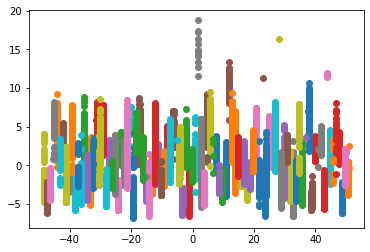

In [38]:
# PCA
X = data
pca = PCA(n_components=2)
pca.fit(X)
x_pca = pca.transform(X)
pca_df = pd.DataFrame(x_pca)
pca_df.reset_index(drop=True)
pca_df["cluster"] = data["cluster"].reset_index(drop=True)

for i in pca_df["cluster"].unique():
    tmp = pca_df.loc[pca_df["cluster"] == i]
    plt.scatter(tmp[0], tmp[1])

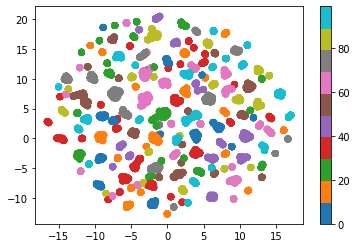

In [39]:
# UMAP
um = umap.UMAP()
um.fit(data)
data_1 = um.transform(data)
plt.scatter(data_1[:, 0], data_1[:, 1], c=clusters.labels_, cmap=cm.tab10)
plt.colorbar()

In [40]:
# 訓連用と評価用に分ける
X = data.iloc[:train_len, :]
test = data.iloc[train_len:, :]
print(X.shape, y.shape, test.shape)

# 訓練用とテスト用に分ける
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, shuffle=True)

print(X_train.shape, y_train.shape)

(19720, 66) (19720,) (29582, 66)
(14790, 66) (14790,)


In [41]:
# RMLSE を計算する

def rmsle_(y_valid, y_pred):
    rmsle = np.sqrt(mean_squared_log_error(np.exp(y_valid), np.exp(y_pred)))
    return rmsle


parameters = {
    'n_estimators': [3, 5, 10, 30, 50],
    'random_state': [7, 42],
    'max_depth': [3, 5, 8, 10],
}

In [42]:
# 交差検証のパラメータ
kfold_cv = KFold(n_splits=5, shuffle=True)

# グリッドサーチで良いパラメータを探す
Grid = GridSearchCV(estimator=RandomForestRegressor(),
                    param_grid=parameters, cv=3)
Grid.fit(X_train, y_train)

best_model = Grid.best_estimator_

train_score = best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)

print("訓練での認識精度:" + str(train_score))
print("テストデータでの認識精度   :" + str(test_score))

print(Grid.best_estimator_)

# モデルの評価

y_pred_test_RF = best_model.predict(X_test)

訓練での認識精度:0.9308739861984183
テストデータでの認識精度   :0.8788501052384039
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=10, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=50, n_jobs=None, oob_score=False,
                      random_state=7, verbose=0, warm_start=False)


In [43]:
# 視聴率は0未満にならない
y_pred_test_RF[y_pred_test_RF < 0] = 0
RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred_test_RF))

print(RMSLE)

0.07461525532349055


In [44]:
a = test.isnull().sum()
a = pd.DataFrame(a)

test["mean"] = test["mean"].fillna(np.mean(test["mean"]))
test["max"] = test["max"].fillna(np.mean(test["max"]))
test["min"] = test["min"].fillna(np.mean(test["min"]))
test["std"] = test["std"].fillna(np.mean(test["std"]))
test["q1"] = test["q1"].fillna(np.mean(test["q1"]))
test["q25"] = test["q25"].fillna(np.mean(test["q25"]))
test["q5"] = test["q5"].fillna(np.mean(test["q5"]))
test["q75"] = test["q75"].fillna(np.mean(test["q75"]))
test["q9"] = test["q9"].fillna(np.mean(test["q9"]))

test.isnull().sum()

y_pred_eval_RF = best_model.predict(test)
y_pred_eval_RF = np.exp(y_pred_eval_RF)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [45]:
# 対数変換していたyを戻す
df_sub_pred = pd.DataFrame(y_pred_eval_RF).rename(columns={0: "y"})
df_sub_pred = pd.concat([test_data['id'], df_sub_pred['y']], axis=1)
df_sub_pred.to_csv("randomforest.csv", index=False)

In [46]:
def rmsle(preds, data):
    y_true = data.get_label()
    y_pred = preds
    y_pred[y_pred < 0] = 0
    y_true[y_true < 0] = 0
    acc = np.sqrt(mean_squared_log_error(np.exp(y_true), np.exp(y_pred)))
    # name, result, is_higher_better
    return 'accuracy', acc, False


# Optunaの最適化パラメータを代入する
light_params = {'task': 'train',  # 他にpredict、convert_model、refitなどもある
                'boosting_type': 'gbdt',
                'objective': 'regression',
                'metric': 'rmse',  # 評価関数
                'verbosity': -1,  # 学習途中を表示しない,-1で表示しない
                "seed": 42,  # シード値
                'learning_rate': 0.01,  # 学習率
                'feature_fraction': 0.7,  # 学習の高速化と過学習の抑制に使用
                'num_leaves': 210}  # ノードの数→葉が多いほど複雑になる

best_params = {'lambda_l1': 0.019918875912078603, 'lambda_l2': 0.002616688073257713, 'num_leaves': 219,
               'feature_fraction': 0.6641013611124621, 'bagging_fraction': 0.7024199018549259, 'bagging_freq': 5, 'min_child_samples': 5}
#best_params =  {}
light_params.update(best_params)

xgb_params = {'learning_rate': 0.1,
              'objective': 'reg:squarederror',
              'eval_metric': 'rmse',
              'seed': 42,
              'tree_method': 'hist'}
best_params = {'learning_rate': 0.01665914389764044,
               'lambda_l1': 4.406831762257336, 'num_leaves': 39}
#best_params = {}
xgb_params.update(best_params)


FOLD_NUM = 11
kf = KFold(n_splits=FOLD_NUM,
           shuffle=True,
           random_state=42)

scores = []
feature_importance_df = pd.DataFrame()
pred_cv = np.zeros(len(test.index))
num_round = 10000

Fold : 0
Training until validation scores don't improve for 100 rounds.
[500]	train's rmse: 0.416146	valid's rmse: 0.788435
[1000]	train's rmse: 0.273111	valid's rmse: 0.777438
[1500]	train's rmse: 0.191979	valid's rmse: 0.775087
Early stopping, best iteration is:
[1634]	train's rmse: 0.175178	valid's rmse: 0.774846
[0]	train-rmse:12.0565	eval-rmse:12.0558
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[500]	train-rmse:0.661381	eval-rmse:0.803302
[1000]	train-rmse:0.564988	eval-rmse:0.791217
Stopping. Best iteration:
[1170]	train-rmse:0.53847	eval-rmse:0.788859



No handles with labels found to put in legend.


best_rmsle= 0.7717702683263443
best_alpha= 0.6900000000000001
Fold : 1
Training until validation scores don't improve for 100 rounds.
[500]	train's rmse: 0.416697	valid's rmse: 0.803075
[1000]	train's rmse: 0.274964	valid's rmse: 0.793756
[1500]	train's rmse: 0.192677	valid's rmse: 0.791736
[2000]	train's rmse: 0.138659	valid's rmse: 0.790781
Early stopping, best iteration is:
[1911]	train's rmse: 0.146671	valid's rmse: 0.790673
[0]	train-rmse:12.0501	eval-rmse:12.12
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[500]	train-rmse:0.656784	eval-rmse:0.82126
[1000]	train-rmse:0.554902	eval-rmse:0.809709
Stopping. Best iteration:
[1043]	train-rmse:0.548507	eval-rmse:0.809133



No handles with labels found to put in legend.


best_rmsle= 0.7895606185849435
best_alpha= 0.84
Fold : 2
Training until validation scores don't improve for 100 rounds.
[500]	train's rmse: 0.416622	valid's rmse: 0.767852
[1000]	train's rmse: 0.273787	valid's rmse: 0.760853
Early stopping, best iteration is:
[1207]	train's rmse: 0.235681	valid's rmse: 0.759554
[0]	train-rmse:12.0633	eval-rmse:11.9878
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[500]	train-rmse:0.661751	eval-rmse:0.783091
[1000]	train-rmse:0.563077	eval-rmse:0.772865
Stopping. Best iteration:
[1011]	train-rmse:0.561223	eval-rmse:0.772672



No handles with labels found to put in legend.


best_rmsle= 0.7570404363839469
best_alpha= 0.76
Fold : 3
Training until validation scores don't improve for 100 rounds.
[500]	train's rmse: 0.415872	valid's rmse: 0.81694
[1000]	train's rmse: 0.273447	valid's rmse: 0.807926
Early stopping, best iteration is:
[1037]	train's rmse: 0.266101	valid's rmse: 0.807828
[0]	train-rmse:12.0585	eval-rmse:12.035
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[500]	train-rmse:0.65279	eval-rmse:0.819352
[1000]	train-rmse:0.559732	eval-rmse:0.806539
Stopping. Best iteration:
[1335]	train-rmse:0.517852	eval-rmse:0.803862



No handles with labels found to put in legend.


best_rmsle= 0.7985045644088878
best_alpha= 0.5
Fold : 4
Training until validation scores don't improve for 100 rounds.
[500]	train's rmse: 0.41716	valid's rmse: 0.755758
[1000]	train's rmse: 0.274935	valid's rmse: 0.745309
[1500]	train's rmse: 0.19337	valid's rmse: 0.74298
Early stopping, best iteration is:
[1745]	train's rmse: 0.164469	valid's rmse: 0.742304
[0]	train-rmse:12.0558	eval-rmse:12.0623
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[500]	train-rmse:0.655428	eval-rmse:0.770679
[1000]	train-rmse:0.559021	eval-rmse:0.755108
[1500]	train-rmse:0.492291	eval-rmse:0.750418
Stopping. Best iteration:
[1474]	train-rmse:0.495515	eval-rmse:0.750316



No handles with labels found to put in legend.


best_rmsle= 0.7392813245566724
best_alpha= 0.66
Fold : 5
Training until validation scores don't improve for 100 rounds.
[500]	train's rmse: 0.420403	valid's rmse: 0.735619
Early stopping, best iteration is:
[796]	train's rmse: 0.325116	valid's rmse: 0.728963
[0]	train-rmse:12.0421	eval-rmse:12.1996
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[500]	train-rmse:0.656404	eval-rmse:0.752535
[1000]	train-rmse:0.56541	eval-rmse:0.746183
Stopping. Best iteration:
[1384]	train-rmse:0.508985	eval-rmse:0.740673



No handles with labels found to put in legend.


best_rmsle= 0.7271223903685036
best_alpha= 0.76
Fold : 6
Training until validation scores don't improve for 100 rounds.
[500]	train's rmse: 0.415674	valid's rmse: 0.770867
[1000]	train's rmse: 0.274016	valid's rmse: 0.759242
[1500]	train's rmse: 0.191923	valid's rmse: 0.757074
Early stopping, best iteration is:
[1497]	train's rmse: 0.19233	valid's rmse: 0.757049
[0]	train-rmse:12.0623	eval-rmse:11.9975
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[500]	train-rmse:0.652628	eval-rmse:0.791471
Stopping. Best iteration:
[747]	train-rmse:0.599985	eval-rmse:0.786158



No handles with labels found to put in legend.


best_rmsle= 0.7560721422906604
best_alpha= 0.9500000000000001
Fold : 7
Training until validation scores don't improve for 100 rounds.
[500]	train's rmse: 0.417239	valid's rmse: 0.766388
[1000]	train's rmse: 0.274923	valid's rmse: 0.756578
[1500]	train's rmse: 0.193446	valid's rmse: 0.754352
[2000]	train's rmse: 0.138768	valid's rmse: 0.753302
Early stopping, best iteration is:
[2294]	train's rmse: 0.11505	valid's rmse: 0.752651
[0]	train-rmse:12.0646	eval-rmse:11.9739
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[500]	train-rmse:0.657326	eval-rmse:0.795091
[1000]	train-rmse:0.562235	eval-rmse:0.783597
[1500]	train-rmse:0.490707	eval-rmse:0.776652
Stopping. Best iteration:
[1530]	train-rmse:0.487025	eval-rmse:0.776032



No handles with labels found to put in legend.


best_rmsle= 0.7506800753193049
best_alpha= 0.89
Fold : 8
Training until validation scores don't improve for 100 rounds.
[500]	train's rmse: 0.41753	valid's rmse: 0.75526
[1000]	train's rmse: 0.273427	valid's rmse: 0.747889
Early stopping, best iteration is:
[1244]	train's rmse: 0.229489	valid's rmse: 0.746635
[0]	train-rmse:12.0528	eval-rmse:12.0927
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[500]	train-rmse:0.65701	eval-rmse:0.789658
[1000]	train-rmse:0.56031	eval-rmse:0.782936
[1500]	train-rmse:0.491561	eval-rmse:0.780023
[2000]	train-rmse:0.436806	eval-rmse:0.777614
Stopping. Best iteration:
[2099]	train-rmse:0.426628	eval-rmse:0.777074



No handles with labels found to put in legend.


best_rmsle= 0.7463890314422245
best_alpha= 1.0
Fold : 9
Training until validation scores don't improve for 100 rounds.
[500]	train's rmse: 0.416513	valid's rmse: 0.738302
[1000]	train's rmse: 0.274259	valid's rmse: 0.729598
[1500]	train's rmse: 0.192461	valid's rmse: 0.727874
Early stopping, best iteration is:
[1542]	train's rmse: 0.187134	valid's rmse: 0.727713
[0]	train-rmse:12.0599	eval-rmse:12.0211
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[500]	train-rmse:0.65494	eval-rmse:0.768588
[1000]	train-rmse:0.563802	eval-rmse:0.763351
Stopping. Best iteration:
[1312]	train-rmse:0.51716	eval-rmse:0.759925



No handles with labels found to put in legend.


best_rmsle= 0.7274632979040774
best_alpha= 1.0
Fold : 10
Training until validation scores don't improve for 100 rounds.
[500]	train's rmse: 0.419486	valid's rmse: 0.727687
[1000]	train's rmse: 0.275603	valid's rmse: 0.713929
[1500]	train's rmse: 0.193477	valid's rmse: 0.711155
[2000]	train's rmse: 0.138963	valid's rmse: 0.709706
Early stopping, best iteration is:
[2124]	train's rmse: 0.128536	valid's rmse: 0.709586
[0]	train-rmse:12.0546	eval-rmse:12.0737
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[500]	train-rmse:0.65848	eval-rmse:0.766699
Stopping. Best iteration:
[846]	train-rmse:0.591345	eval-rmse:0.754422



No handles with labels found to put in legend.


best_rmsle= 0.7090053238914714
best_alpha= 1.0


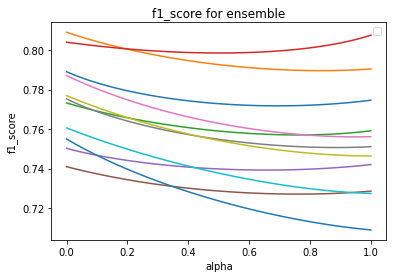

In [47]:
# iは交差検証の回数 tdxとvdxはランダムに選ばれたtrain,testのインデックス
for i, (tdx, vdx) in enumerate(kf.split(X, y)):
    print(f'Fold : {i}')
    # LGB
    # なぜy.valuesなのか　これだけわかればここのコード行ける！
    X_train, X_valid, y_train, y_valid = X.iloc[tdx], X.iloc[vdx], y.values[tdx], y.values[vdx]

    # LGB
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_valid, y_valid)
    gbc = lgb.train(light_params, lgb_train, num_boost_round=num_round,
                    valid_names=["train", "valid"], valid_sets=[lgb_train, lgb_valid],
                    # feval=rmsle,
                    early_stopping_rounds=100, verbose_eval=500)
    if i == 0:
        importance_df = pd.DataFrame(
            gbc.feature_importance(), index=X.columns, columns=['importance'])
    else:
        importance_df += pd.DataFrame(gbc.feature_importance(),
                                      index=X.columns, columns=['importance'])
    gbc_va_pred = np.exp(gbc.predict(
        X_valid, num_iteration=gbc.best_iteration))
    gbc_va_pred[gbc_va_pred < 0] = 0

    # XGB
    xgb_dataset = xgb.DMatrix(X_train, label=y_train)
    xgb_test_dataset = xgb.DMatrix(X_valid, label=y_valid)
    xgbm = xgb.train(xgb_params, xgb_dataset, 10000, evals=[(xgb_dataset, 'train'), (xgb_test_dataset, 'eval')],
                     early_stopping_rounds=100, verbose_eval=500)
    xgbm_va_pred = np.exp(xgbm.predict(xgb.DMatrix(X_valid)))
    xgbm_va_pred[xgbm_va_pred < 0] = 0

    # ENS
    # lists for keep results
    lgb_xgb_rmsle = []
    lgb_xgb_alphas = []

    for alpha in np.linspace(0, 1, 101):  # (0 ~ 1までランダムな数を100回生成する)
        # このlgbとxgbアンサンブルめちゃくちゃ旨い！
        y_pred = alpha*gbc_va_pred + (1 - alpha)*xgbm_va_pred
        rmsle_score = np.sqrt(mean_squared_log_error(np.exp(y_valid), y_pred))

        # スコアとランダムな数値を格納
        lgb_xgb_rmsle.append(rmsle_score)
        lgb_xgb_alphas.append(alpha)

    # ndarrayに変換
    lgb_xgb_rmsle = np.array(lgb_xgb_rmsle)
    lgb_xgb_alphas = np.array(lgb_xgb_alphas)

    # rmsleが一番低い(ベストなスコア)時のインデックスを得て、alphaを格納
    lgb_xgb_best_alpha = lgb_xgb_alphas[np.argmin(lgb_xgb_rmsle)]

    print('best_rmsle=', lgb_xgb_rmsle.min())
    print('best_alpha=', lgb_xgb_best_alpha)

    plt.plot(lgb_xgb_alphas, lgb_xgb_rmsle)
    plt.title('f1_score for ensemble')
    plt.xlabel('alpha')
    plt.ylabel('f1_score')
    plt.legend()

    score_ = lgb_xgb_rmsle.min()
    scores.append(score_)
    # 一番良かったスコアをappendする

    lgb_submission = np.exp(gbc.predict(
        (test), num_iteration=gbc.best_iteration))
    lgb_submission[lgb_submission < 0] = 0

    xgbm_submission = np.exp(xgbm.predict(xgb.DMatrix(test)))
    xgbm_submission[xgbm_submission < 0] = 0

    submission = lgb_xgb_best_alpha*lgb_submission + \
        (1 - lgb_xgb_best_alpha)*xgbm_submission  # 上のアンサンブルの仕方と一緒

    # FOLD_NUM個分の答えになっているので割る
    # これをFOLD_NUM回繰り返すのでpred_cvは良い感じの答えになる
    pred_cv += submission/FOLD_NUM


In [48]:
print("##########")
print(np.mean(scores))

light_submission_df = pd.concat([iddf, pd.DataFrame(pred_cv)], axis=1)
light_submission_df.columns = ["id", "y"]
light_submission_df.to_csv("submission_lgb.csv", index=False)
print("end")


##########
0.7520808612251852
end
